In [136]:
from numpy import array
import numpy as np
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
import pandas as pd

from math import log
from math import exp
from scipy.stats import boxcox



In [137]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [138]:
def invert_boxcox(value, lam):
	# log case
	if lam == 0:
		return exp(value)
	# all other cases
	return exp(log(lam * value + 1) / lam)

In [139]:
# data = pd.read_csv("Timeseries_real_data_interview.csv")
# t = data.iloc[0:11964] #11565
# v = data.iloc[11964:19940]
# ts = data.iloc[19940:20001]
data = pd.read_excel("test data.xlsx")
t = data.iloc[0:192] #11565
v = data.iloc[180:228]
ts = data.iloc[228:252]
# pl=data.iloc[0:252]
# define input sequence
train_seq = t['Bãi Cháy'].values
val_seq = v['Bãi Cháy'].values
test_seq = ts['Bãi Cháy'].values
# plot_seq = pl['Bãi Cháy'].values
# print(test_seq)
tr, tr_lamb = boxcox(train_seq)
vl, vl_lamb = boxcox(val_seq)
ts, ts_lamb = boxcox(test_seq)

print('Training Sequence : %d'%len(train_seq))
print('Validation Sequence : %d'%len(val_seq))
print('Testing Sequence : %d'%len(test_seq))

Training Sequence : 192
Validation Sequence : 48
Testing Sequence : 24


In [140]:
n_steps_in, n_steps_out = 12, 12
# split into samples
X_train, y_train = split_sequence(tr, n_steps_in, n_steps_out)
X_val, y_val = split_sequence(vl, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(ts, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (169, 12, 1)
X_val shape: (25, 12, 1)
X_test shape: (1, 12, 1)


In [141]:
import keras.backend as kb

def r2_score(y_true, y_pred):
    ss_res = kb.sum(kb.square(y_true - y_pred))
    ss_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return (1 - ss_res/(ss_tot + kb.epsilon()))

model = Sequential()
model.add(Conv1D(filters=126, kernel_size=2, activation='tanh', input_shape=(n_steps_in, n_features), kernel_regularizer=keras.regularizers.l2(l=0.01), kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))

adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse', metrics=[r2_score, 'mae', keras.metrics.RootMeanSquaredError()])

In [142]:
history = model.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val, y_val), batch_size=64)


Epoch 1/200


3/3 [==============================] - 1s 104ms/step - loss: 72.2332 - r2_score: -4.4549 - mae: 7.4897 - root_mean_squared_error: 8.3500 - val_loss: 38.3884 - val_r2_score: -4.5222 - val_mae: 5.4351 - val_root_mean_squared_error: 5.9903
Epoch 2/200
3/3 [==============================] - 0s 20ms/step - loss: 50.6138 - r2_score: -2.7406 - mae: 6.0244 - root_mean_squared_error: 6.9362 - val_loss: 23.9712 - val_r2_score: -2.3047 - val_mae: 4.0127 - val_root_mean_squared_error: 4.6340
Epoch 3/200
3/3 [==============================] - 0s 21ms/step - loss: 35.6761 - r2_score: -1.5880 - mae: 4.8451 - root_mean_squared_error: 5.7603 - val_loss: 14.7220 - val_r2_score: -0.8824 - val_mae: 2.7795 - val_root_mean_squared_error: 3.4974
Epoch 4/200
3/3 [==============================] - 0s 23ms/step - loss: 25.1924 - r2_score: -0.7728 - mae: 3.9354 - root_mean_squared_error: 4.7649 - val_loss: 10.0788 - val_r2_score: -0.1689 - val_mae: 2.1325 - val_root_mean_squared_error: 2.7561
Epoch 5/200
3/3 [==

In [143]:
# y_pred = model.predict(X_test)
# print(y_pred)
# print(X_test)
last_epoch_metrics = {
    'loss': history.history['loss'][-1],
    'r2_score': history.history['r2_score'][-1],
    'mae': history.history['mae'][-1],
    'rmse': history.history['root_mean_squared_error'][-1]
}
print(last_epoch_metrics)

{'loss': 5.776071548461914, 'r2_score': 0.641808271408081, 'mae': 1.6873829364776611, 'rmse': 2.1201741695404053}


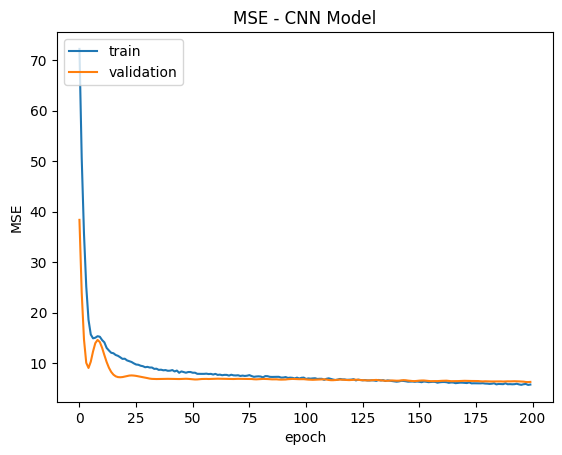

In [144]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE - CNN Model')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('saved/cnn/loss.png')
plt.show()

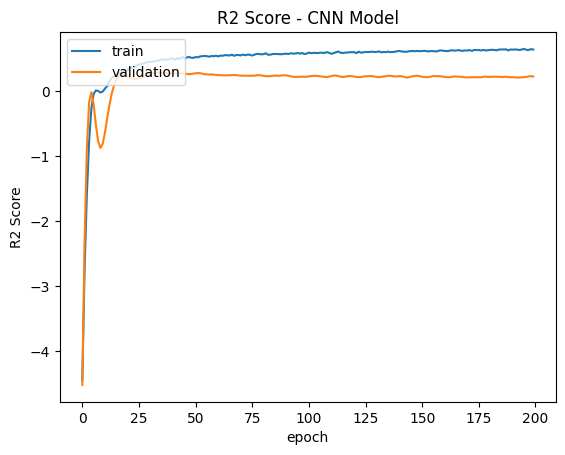

In [145]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('R2 Score - CNN Model')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('saved/cnn/r2_score.png')
plt.show()

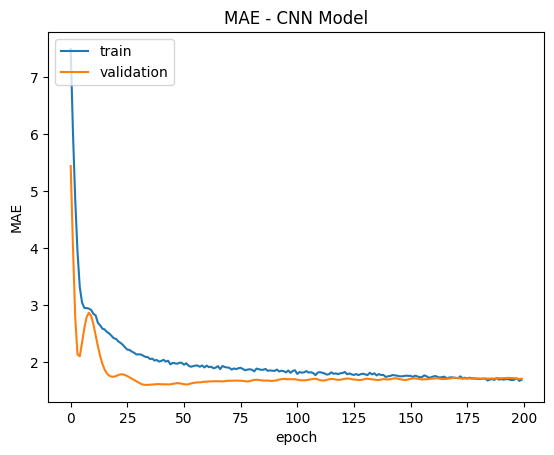

In [146]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE - CNN Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('saved/cnn/mae.png')
plt.show()

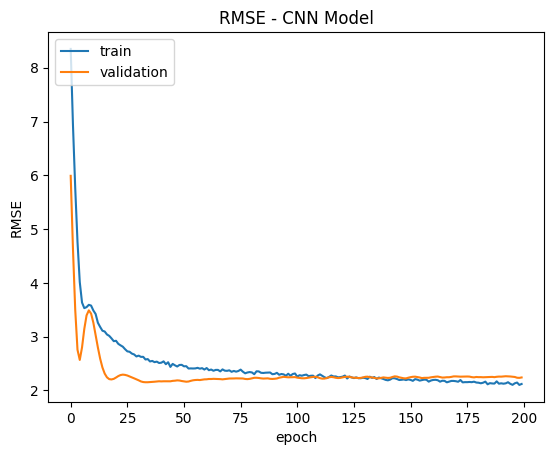

In [147]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE - CNN Model')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('saved/cnn/rmse.png')
plt.show()